#Transfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model of your choice on a sub-dataset from the [MedMNIST datasets](https://medmnist.com/). ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook and/or in your final forum post.




# 1. Install & Import Packages

In [136]:
!pip install medmnist
!pip install torchinfo


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [137]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import os
from torchinfo import summary
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn.utils import clip_grad_norm_

import torch

## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of input channels below that will affect your model)



In [138]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'dermamnist' # 3×28×28
download = True

BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
classes = info['label']

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  7
The batch size for this dataset will be =  128


In [139]:
from torch.utils.tensorboard import SummaryWriter
import time

run_name = f"exp_{int(time.time())}"
writer = SummaryWriter(log_dir=f"runs2/{run_name}")

In [140]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

torch.manual_seed(42)

if device == 'cuda':
    # this part was added as I noticed with each run i would get a different result
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    print("CuDNN benchmark / deterministic mode ENABLED") # since we have a fixed input of images may as well put the machine to work - faster convolution


Using cuda device
CuDNN benchmark / deterministic mode ENABLED


In [141]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def fetch_accuracy(y_true, y_pred):

    acc_A = accuracy_score(y_true, y_pred)
    f1_macro_A = f1_score(y_true, y_pred, average='macro')

    print(classification_report(y_true, y_pred))
    print(f"Model A → Acc: {acc_A:.3f}, Macro-F1: {f1_macro_A:.3f}")

def fetch_train_object(preprocess, batch_size, size, num_workers, pin_memory, download) :

    train_dataset = DataClass(split='train', transform=preprocess, download=download, size=size, mmap_mode='r')

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory,
                                  prefetch_factor=4,      # range 2- 8
                                  persistent_workers=True)

    print(f'Train Samples {len(train_dataloader.dataset)} - Train Batches {len(train_dataloader)}')

    return train_dataset, train_dataloader

def fetch_test_object(preprocess, batch_size, size, num_workers, pin_memory,download):

    test_dataset = DataClass(split='test', transform=preprocess, download=download, size=size, mmap_mode='r')

    test_dataloader =  DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=pin_memory,
                                 prefetch_factor=4,      # range 2- 8
                                 persistent_workers=True)

    print(f'Test Samples {len(test_dataloader.dataset)} - Test Batches {len(test_dataloader)}')

    return test_dataset, test_dataloader

def fetch_v_object(preprocess, batch_size, size, num_workers, pin_memory, download):

    val_dataset = DataClass(split='val', transform=preprocess, download=download, size=size, mmap_mode='r')

    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=pin_memory,
                                 prefetch_factor=4,      # range 2- 8
                                 persistent_workers=True)

    print(f'Val Samples {len(val_dataloader.dataset)} - Val Batches {len(val_dataloader)}')

    return val_dataset, val_dataloader

In [142]:
# get all the layers
# conv1
# bn1
# relu
# maxpool
# layer1
# layer2
# layer3
# layer4
# avgpool
# fc
resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image. However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, the gap between the original ImageNet domain and the medical images is wide. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.


Plot some example augmented images

# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [143]:
import torch
import torch.nn as nn
from torchvision import models

weights = ResNet18_Weights.IMAGENET1K_V1
pretrained_model = models.resnet18(weights=weights, progress=True)

preprocess = weights.transforms()
print(preprocess)

IMAGE_SIZE =  224

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [144]:
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

num_workers = min(8, os.cpu_count() or 1)
pin_memory = (device == 'cuda')

train_transforms = v2.Compose([
        v2.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)), # helps to exit the 83 % - without any data manipulation stuck on 83%
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5), # 88%
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = v2.Compose([ # adding here anythign affects  the %
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset, train_dataloader = fetch_train_object(train_transforms, BATCH_SIZE, IMAGE_SIZE, num_workers, pin_memory, download)
val_dataset, val_dataloader = fetch_v_object(val_test_transform, BATCH_SIZE, IMAGE_SIZE, num_workers, pin_memory, download)
test_dataset, test_dataloader = fetch_test_object(val_test_transform, BATCH_SIZE, IMAGE_SIZE, num_workers, pin_memory, download)

print(f"Print")

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Train Samples 7007 - Train Batches 55
Val Samples 1003 - Val Batches 8
Test Samples 2005 - Test Batches 16
Print
Shape of X [N, C, H, W]: torch.Size([128, 3, 224, 224])
Shape of y: torch.Size([128, 1]) torch.int64


In [145]:
def train_one_epoch_at_a_time(model, train_dataloader, device, loss_fn, optimizer):
    model.train()

    running_loss = running_corrects = total = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device, non_blocking=True) , labels.to(device, non_blocking=True)

        labels = labels.view(-1).long() # always get a 1d labels

        optimizer.zero_grad()

        with torch.autocast(device, dtype=torch.bfloat16): # BOOST CALCULATIONS  ON gpu
            outputs = model(images)                        # forward pass
            _, predicted = torch.max(outputs, 1)           # predicted class highest score
            loss = loss_fn(outputs, labels)                # calculate loss

            loss.backward()                      # backward pass

            clip_grad_norm_(model.parameters(), max_norm=1.0) # FORCING THE GAP TO CLOSE INCREASE %

            optimizer.step()                     # run optimisation

            # DETACH PREVENTS MEMORY LEAKS - copy to CPU explicitly
            running_loss += loss.detach().item() * images.size(0)
            running_corrects += predicted.eq(labels.detach()).sum().item()
            total += labels.size(0)

    epoch_avg_loss = running_loss / total
    epoch_acc  = 100. * running_corrects / total

    return epoch_avg_loss, epoch_acc

@torch.inference_mode() # we dont need gradient for testing and validation - GPU SPEED UP
def validate_one_epoch_at_a_time(model, val_dataloader, device, loss_fn):
    model.eval()

    running_loss = running_corrects = total = 0.0

    for images, labels in val_dataloader:
        images, labels = images.to(device, non_blocking=True) , labels.to(device, non_blocking=True)

        labels = labels.view(-1).long() # always get a 1d labels

        with torch.autocast(device, dtype=torch.bfloat16): # BOOST CALCULATIONS  ON gpu
            outputs = model(images)               # forward pass
            _, predicted = torch.max(outputs, 1)  # predicted class highest score
            loss = loss_fn(outputs, labels)       # calculate loss

        running_loss += loss.detach().item() * images.size(0)
        running_corrects += predicted.eq(labels.detach()).sum().item()
        total += labels.size(0)

    epoch_avg_loss = running_loss / total
    epoch_acc  = 100. * running_corrects / total

    return epoch_avg_loss, epoch_acc

@torch.inference_mode() # we dont need gradient for testing and validation - GPU SPEED UP
def final_evaluation(model, test_dataloader, device):
    model.eval()

    y_true, y_pred = [], []
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        predicted = model(inputs).argmax(dim=1)

        y_true.append(labels)       # dont trigger CPU
        y_pred.append(predicted)

    y_true = torch.cat(y_true).cpu().numpy() # trigger CPU now that we have the stats
    y_pred = torch.cat(y_pred).cpu().numpy()

    return  y_true, y_pred

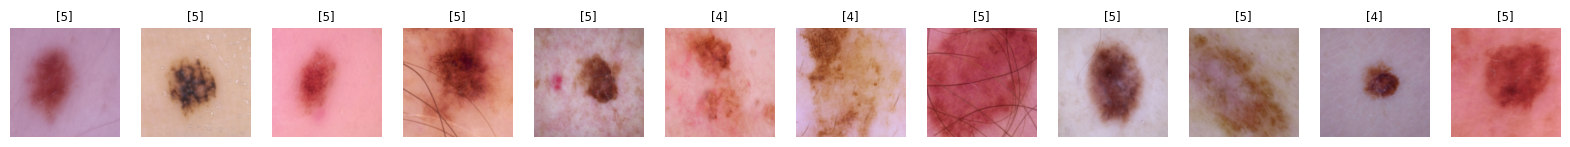

In [146]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1

# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

  8%|▊         | 1/12 [00:24<04:25, 24.11s/it]

Best Val Acc=75.174 Ph1 0


 58%|█████▊    | 7/12 [00:45<00:21,  4.40s/it]

Best Val Acc=76.072 Ph1 6


100%|██████████| 12/12 [01:03<00:00,  5.25s/it]


PH2


  1%|          | 1/120 [00:03<07:24,  3.74s/it]

Best Val Acc=78.764 Ph2 0


  2%|▏         | 2/120 [00:07<07:31,  3.83s/it]

Best Val Acc=79.960 Ph2 1


  2%|▎         | 3/120 [00:11<07:17,  3.74s/it]

Best Val Acc=81.755 Ph2 2


  5%|▌         | 6/120 [00:22<06:58,  3.67s/it]

Best Val Acc=82.652 Ph2 5


  6%|▌         | 7/120 [00:25<06:52,  3.65s/it]

Best Val Acc=85.643 Ph2 6


 14%|█▍        | 17/120 [01:02<06:15,  3.65s/it]

Best Val Acc=86.042 Ph2 16


 16%|█▌        | 19/120 [01:09<06:11,  3.68s/it]

Best Val Acc=87.338 Ph2 18


 25%|██▌       | 30/120 [01:51<05:33,  3.70s/it]

Best Val Acc=87.537 Ph2 29


 28%|██▊       | 34/120 [02:05<05:19,  3.72s/it]

Best Val Acc=87.936 Ph2 33


 29%|██▉       | 35/120 [02:09<05:19,  3.76s/it]

Best Val Acc=88.235 Ph2 34


 30%|███       | 36/120 [02:13<05:15,  3.76s/it]

Best Val Acc=88.534 Ph2 35


 32%|███▏      | 38/120 [02:21<05:12,  3.81s/it]

Best Val Acc=88.634 Ph2 37


 34%|███▍      | 41/120 [02:32<05:05,  3.87s/it]

Best Val Acc=88.833 Ph2 40


 35%|███▌      | 42/120 [02:36<04:56,  3.81s/it]

Best Val Acc=88.933 Ph2 41


 41%|████      | 49/120 [03:03<04:29,  3.79s/it]

Best Val Acc=89.332 Ph2 48


 42%|████▎     | 51/120 [03:10<04:18,  3.75s/it]

Best Val Acc=89.432 Ph2 50


 45%|████▌     | 54/120 [03:22<04:08,  3.76s/it]

Best Val Acc=89.631 Ph2 53


 50%|█████     | 60/120 [03:44<03:42,  3.71s/it]

Best Val Acc=89.831 Ph2 59


 51%|█████     | 61/120 [03:48<03:44,  3.80s/it]

Best Val Acc=90.229 Ph2 60


 75%|███████▌  | 90/120 [05:42<01:54,  3.80s/it]

Early stopping at epoch 90


              precision    recall  f1-score   support

           0       0.95      0.62      0.75        66
           1       0.78      0.82      0.80       103
           2       0.86      0.84      0.85       220
           3       0.89      0.74      0.81        23
           4       0.76      0.75      0.76       223
           5       0.94      0.97      0.95      1341
           6       0.96      0.86      0.91        29

    accuracy                           0.90      2005
   macro avg       0.88      0.80      0.83      2005
weighted avg       0.90      0.90      0.90      2005



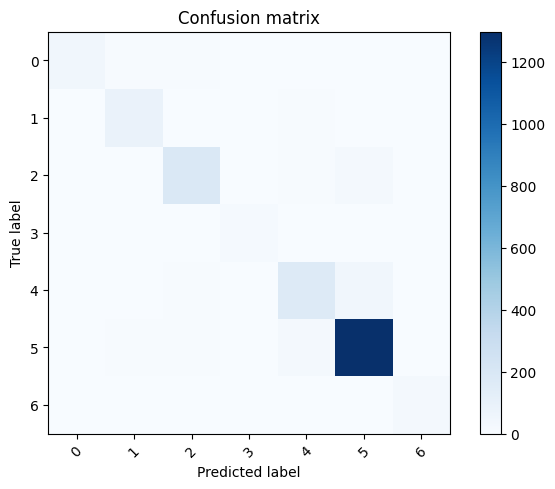

In [147]:
from torch.optim.lr_scheduler import OneCycleLR

#Phase 1:

# since we are going for the 224 * 224 images

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(512, 7)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001, nesterov=True)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# train fc only
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

best_val_acc = 0.0
for epoch in tqdm(range(12)): # no point in going above values gets stuck
    train_loss, train_acc = train_one_epoch_at_a_time(model, train_dataloader, device, loss_fn, optimizer)
    val_loss,   val_acc   = validate_one_epoch_at_a_time(model, val_dataloader, device, loss_fn)

    writer.add_scalars('Loss',     {'Training Loss' : train_loss, 'Validation Loss' : val_loss }, epoch+1)
    writer.add_scalars('Accuracy', {'Training Acc'  : train_acc, 'Validation Acc'   : val_acc  }, epoch+1)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best Val Acc={val_acc:.3f} Ph1 {epoch}")

# we exit phase 1 with 76% - so jump to 80 % in a couple of epochs
#Phase 2:

model.load_state_dict(torch.load("best_model.pth"))

print(f"PH2")

# train rest
for param in model.parameters():
    param.requires_grad = True

# 0.03 helps to move out of values (0.01 - stuck in vales forever )
# 0.05 - jump to 90
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001, nesterov=True)
#
#
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120, eta_min=1e-6)

# train and validate
best_val_acc = 0.0
patience = 30
patience_counter = 0
for epoch in tqdm(range(120)): # bumped from 60 to 80 ()
    train_loss, train_acc = train_one_epoch_at_a_time(model, train_dataloader, device, loss_fn, optimizer)
    val_loss,   val_acc   = validate_one_epoch_at_a_time(model, val_dataloader, device, loss_fn)

    scheduler.step()

    writer.add_scalars('Loss',     {'Training Loss' : train_loss, 'Validation Loss' : val_loss }, epoch+1)
    writer.add_scalars('Accuracy', {'Training Acc'  : train_acc, 'Validation Acc'   : val_acc  }, epoch+1)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"Best Val Acc={val_acc:.3f} Ph2 {epoch}")
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# final test validation
model.load_state_dict(torch.load("best_model.pth"))
y_true, y_pred = final_evaluation(model, test_dataloader, device)

# evaluate results

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=classes))
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes)

In [148]:
%tensorboard --logdir=runs --port=6006 --bind_all

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
!pip install tensorboard

# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



In [ ]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
image_batch = image_batch.to(device)
pred_logit = model(image_batch)


# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(25,10))


for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")

  predicted_idx = pred_logit[i,:].argmax(0).item()   # convert tensor → int
  actual_idx = labels_batch[i].item()               # convert tensor → int
  predicted, actual = classes[str(predicted_idx)], classes[str(actual_idx)]

  color = 'black' if predicted == actual else 'red'
  axarr[i].set_title(predicted,fontsize='small', color=color)
  i = i+1

 # Comments about your Approach

In [ ]:
On the web post - I was sick so results are not great for this assigment